# Examples of Making Sky Plots from BOSS Meta Data

Examples of using the [Basemap](http://matplotlib.org/basemap/) and [healpy](https://healpy.readthedocs.org/en/latest/) packages to make all sky maps of meta data accessed with the [bossdata](http://bossdata.readthedocs.org/) package.  We use data from the BOSS quasar catalog.

## Package Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import healpy as hp
print hp.version.__version__

1.8.6


In [5]:
import bossdata.meta
print bossdata.__version__

0.2.7dev


## Query Database

Get list of ra, dec, z, and warning flags for quasar observations.

In [6]:
quasar_catalog = bossdata.meta.Database(quasar_catalog=True, lite=False)

In [7]:
quasar_table = quasar_catalog.select_all(what='RA,DEC,Z_VI,BAL_FLAG_VI,ZWARNING', max_rows=0)
print 'Found {0} total quasars'.format(len(quasar_table))

Found 297301 total quasars


In [8]:
bal_flagged = quasar_table[quasar_table['BAL_FLAG_VI'] != 0]
print 'Found {0} with BAL identified from visual inspection'.format(len(bal_flagged))

Found 29580 with BAL identified from visual inspection


In [9]:
zwarning_flagged = quasar_table[quasar_table['ZWARNING'] != 0]
print 'Found {0} with ZWARNING from pipepline'.format(len(zwarning_flagged))

Found 13896 with ZWARNING from pipepline


In [10]:
hiz_quasars = quasar_table[(quasar_table['Z_VI'] > 2.1) & (quasar_table['Z_VI'] < 3.5)]
print 'Found {0} in high redshift sample (2.1 < z < 3.5)'.format(len(hiz_quasars))

Found 181605 in high redshift sample (2.1 < z < 3.5)


In [11]:
np.min(quasar_table['Z_VI']), np.max(quasar_table['Z_VI'])

(0.040969144552946091, 6.4400000000000004)

Plot redshift distribution of quasar observations

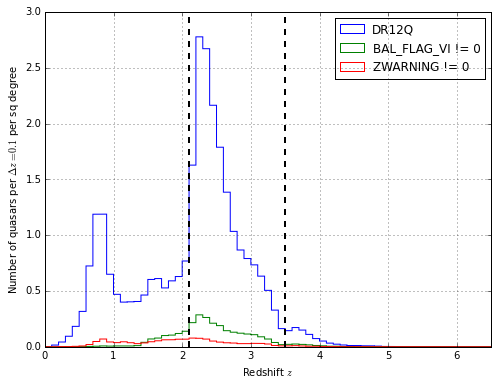

In [12]:
plt.figure(figsize=(8,6))
dr12_survey_area = 10400.0 # square degrees
wgt = 1.0/dr12_survey_area
zbins = np.linspace(0,6.5,66)
plt.hist(quasar_table['Z_VI'], weights=wgt*np.ones(len(quasar_table)), label='DR12Q', bins=zbins, histtype='step')
plt.hist(bal_flagged['Z_VI'], weights=wgt*np.ones(len(bal_flagged)), label='BAL_FLAG_VI != 0', bins=zbins, histtype='step')
plt.hist(zwarning_flagged['Z_VI'], weights=wgt*np.ones(len(zwarning_flagged)), label='ZWARNING != 0', bins=zbins, histtype='step')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of quasars per $\Delta z = %.1f$ per sq degree' % (zbins[1]-zbins[0]))
plt.axvline(2.1, c='k', ls='--', lw=2)
plt.axvline(3.5, c='k', ls='--', lw=2)
plt.xlim(0,6.5)
plt.grid()
plt.legend()
plt.show()

## Sky Plots

Plot an "all sky map" using healpix binning:

In [13]:
def plot_sky(ra, dec, data=None, nside=16, label='', projection='eck4', cmap=plt.get_cmap('jet'), norm=None):
    # get pixel area in degrees
    pixel_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
    # find healpixels associated with input vectors
    pixels = hp.ang2pix(nside, 0.5*np.pi-np.radians(dec), np.radians(ra))
    # find unique pixels
    unique_pixels = np.unique(pixels)
    # count number of points in each pixel
    bincounts = np.bincount(pixels)
    # if no data provided, show counts per sq degree
    # otherwise, show mean per pixel
    if data is None:
        values = bincounts[unique_pixels]/pixel_area
    else:
        weighted_counts = np.bincount(pixels, weights=data)
        values = weighted_counts[unique_pixels]/bincounts[unique_pixels]
    # find pixel boundaries
    corners = hp.boundaries(nside, unique_pixels, step=1)
    corner_theta, corner_phi = hp.vec2ang(corners.transpose(0,2,1))
    corner_ra, corner_dec = np.degrees(corner_phi), np.degrees(np.pi/2-corner_theta)
    # set up basemap
    m = Basemap(projection=projection, lon_0=90, resolution='l', celestial=True)
    m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,1,0], labelstyle='+/-')
    m.drawparallels(np.arange(-90, 90, 15), labels=[1,0,0,0], labelstyle='+/-')
    m.drawmapboundary()
    # convert sky coords to map coords 
    x,y = m(corner_ra, corner_dec)
    # regroup into pixel corners
    verts = np.array([x.reshape(-1,4), y.reshape(-1,4)]).transpose(1,2,0)
    # Make the collection and add it to the plot.
    coll = PolyCollection(verts, array=values, cmap=cmap, norm=norm, edgecolors='none')
    plt.gca().add_collection(coll)
    plt.gca().autoscale_view()
    # Add a colorbar for the PolyCollection
    plt.colorbar(coll, orientation='horizontal', pad=0.01, aspect=40, label=label)
    return m

#### Show distribution on sky

Plot the number of quasars per square degree:

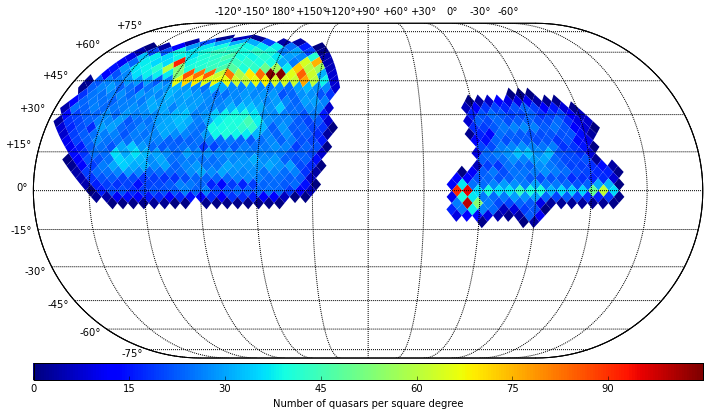

In [14]:
plt.figure(figsize=(12,9))
plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, label='Number of quasars per square degree')
plt.show()

Plot the number of high redshift quasars per square degree

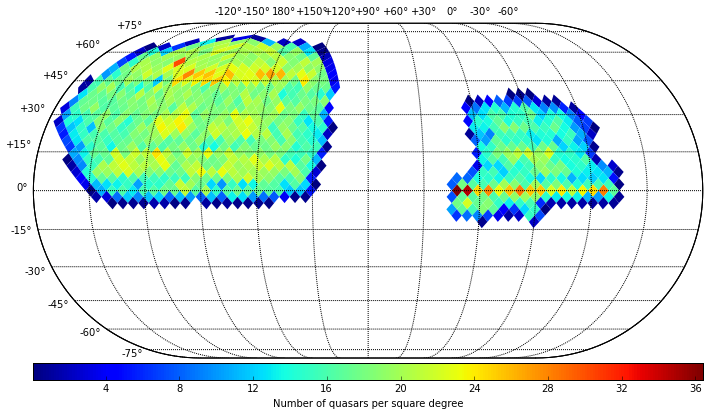

In [15]:
plt.figure(figsize=(12,9))
plot_sky(hiz_quasars['RA'].data, hiz_quasars['DEC'].data, label='Number of quasars per square degree')
plt.show()

#### Show mean redshift on sky

We can show the mean value of a quantity on the sky as well

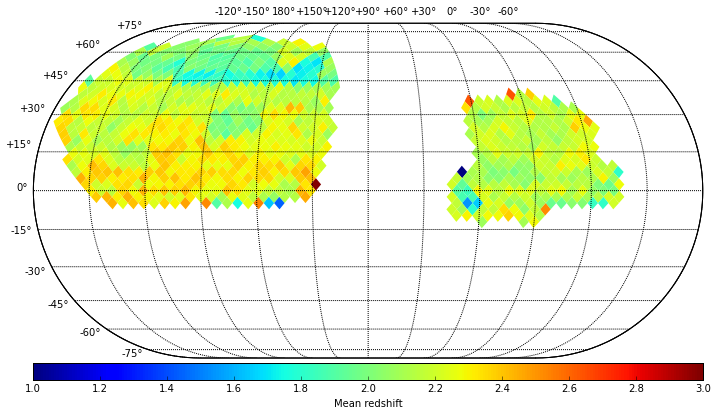

In [20]:
plt.figure(figsize=(12,9))
plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, data=quasar_table['Z_VI'].data,
         label='Mean redshift', nside=16,
         norm=mpl.colors.Normalize(vmin=1, vmax=3))
plt.show()

In [ ]:
Using

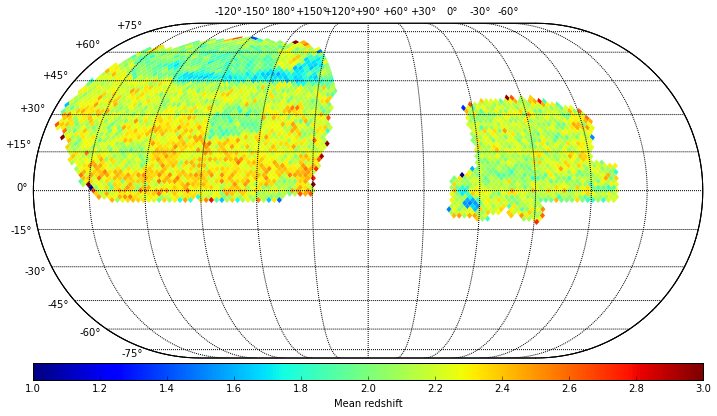

In [18]:
plt.figure(figsize=(12,9))
plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, data=quasar_table['Z_VI'].data,
         label='Mean redshift', nside=32,
         norm=mpl.colors.Normalize(vmin=1, vmax=3))
plt.show()

#### Show galactic plane

Use astropy to show the galactic plane

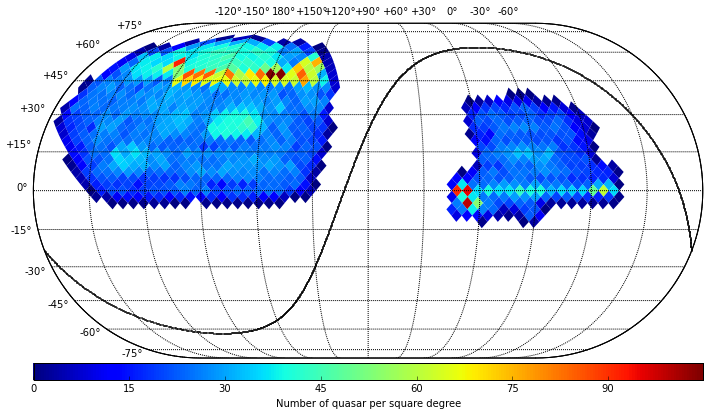

In [17]:
plt.figure(figsize=(12,9))
m = plot_sky(quasar_table['RA'].data, quasar_table['DEC'].data, label='Number of quasar per square degree')
# generate vector in galactic coordinates  and convert to equatorial coordinates
galactic_l = np.linspace(0, 2*np.pi, 1000)
galactic_plane = SkyCoord(l=galactic_l*u.radian, b=np.zeros_like(galactic_l)*u.radian, frame='galactic').fk5
# project to map coordinates
x, y = m(galactic_plane.ra.degree, galactic_plane.dec.degree)
m.scatter(x, y, marker='.', s=2, c='k')
plt.show()